# Assessment - Model Ensembling (Voting)

We'll just kick things off with some important imports, and get straight to the task at hand!

## Imports

In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt


## Loading and Splitting the Clean Data

Since the data is already cleaned/nicely split into a train and test set - we'll just load it in, move it to the correct dataframes - and then split our train into train and validation. Going with a 80/20 split since we have 24k rows seems appropriate

In [2]:
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")

# get X_train, X_test, y_train, y_test
X_train = train_df.drop(["Y"], axis=1)
y_train = train_df["Y"]
X_test = test_df.drop(["Y"], axis=1)
y_test = test_df["Y"]

# cast y_train and y_test to categorical
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

# split the training data into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=0
)

# fit the scaler on the training data
scaler = StandardScaler()
scaler.fit(X_train)

# transform the training and validation data
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


## Create and run the "Model Factory"

We'll create a single function that accepts a list of ints and returns a NN that can be used in a 10 classification problem

In [3]:
def model_factory(
    input_size: int, list_of_neurons: list, learning_rate: float = 0.01
) -> Sequential:
    """
    Builds a model with the given parameters.

    Parameters
    ----------
    input_size : int
        The number of features in the input.
    list_of_neurons : list
        A list of integers representing the number of neurons in each layer.
    learning_rate : float
        The learning rate for the model.

    Returns
    -------
    Sequential
        A model with the given parameters.
    """

    # init the model
    model = Sequential()
    # add the first layer
    model.add(Dense(list_of_neurons[0], input_dim=input_size, activation="relu"))
    # add the rest of the layers
    for i in range(1, len(list_of_neurons)):
        model.add(Dense(list_of_neurons[i], activation="relu"))
    # add the output layer
    model.add(Dense(10, activation="softmax"))
    # compile the model
    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=["accuracy"],
    )
    return model


In [4]:
# input dimension
input_dim = X_train.shape[1]

# model parameters
model_params_1 = [input_dim, [256, 64, 32, 16], 0.01]
model_params_2 = [input_dim, [256, 256, 64, 32], 0.005]
model_params_3 = [input_dim, [128, 128, 64, 32], 0.001]
model_params_4 = [input_dim, [128, 128, 128, 64, 32], 0.0005]
model_params_5 = [input_dim, [256, 128, 64, 32], 0.0001]

# list of model parameters
model_params_list = [
    model_params_1,
    model_params_2,
    model_params_3,
    model_params_4,
    model_params_5,
]

# create a list of models
model_list = [model_factory(*model_params) for model_params in model_params_list]


## Create the Ensemble Class

Here we create the ensemble class including training for the base models, as well as predictions

### Helper Functions

In [5]:
def plot_train_loss(history: tf.keras.callbacks.History) -> None:
    """
    Plots the training loss for each model.

    Parameters
    ----------
    history : tf.keras.callbacks.History
        The history of the training.

    Returns
    -------
    None
    """

    # plot the loss and accuracy
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    epochs = range(1, len(loss) + 1)

    # plot the loss
    plt.figure()
    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # plot the accuracy
    plt.figure()
    plt.plot(epochs, acc, "bo", label="Training acc")
    plt.plot(epochs, val_acc, "b", label="Validation acc")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


In [6]:
class EnsembleModel:
    """
    An ensemble model.

    Attributes
    ----------
    models : list
        A list of base models.

    Methods
    -------
    train_base_models(
        x: pd.Dataframe,
        y: pd.Dataframe,
        x_val: pd.Dataframe,
        y_val: pd.Dataframe,
        epochs: int
    )
        Trains the base models.

    predict_and_score(
        x: pd.Dataframe,
        y: pd.Dataframe
    )
        Predicts and scores the ensemble model.
    """

    def __init__(self, models: list):
        """
        Initializes the ensemble model.

        Parameters
        ----------
        models : list
            A list of models.
        """
        super().__init__()
        self.models = models
        self.trained = False

    def train_base_models(
        self,
        x_train_df: pd.DataFrame,
        y_train_df: pd.DataFrame,
        x_val_df: pd.DataFrame,
        y_val_df: pd.DataFrame,
        epochs: int = 10,
    ) -> None:
        """
        Trains the base models.

        Parameters
        ----------
        x : pd.DataFrame
            The training data.
        y : pd.DataFrame
            The training labels.
        x_val : pd.DataFrame
            The validation data.
        y_val : pd.DataFrame
            The validation labels.
        epochs : int
            The number of epochs to train the models.
        """

        # train each model
        for model in self.models:
            model.fit(
                x_train_df,
                y_train_df,
                epochs=epochs,
                batch_size=256,
                validation_data=(x_val_df, y_val_df),
                verbose=0,
            )

        # fit the models
        for idx, model in enumerate(self.models):
            history = model.fit(
                x_train_df, y_train_df, epochs=epochs, validation_data=(x_val_df, y_val_df), verbose=0
            )

            print(f"Model {idx+1}\n")

            # plot the loss and accuracy
            plot_train_loss(history)

        # set the trained flag to True
        self.trained = True

    def predict_and_score(self, x_to_predict: pd.DataFrame, y_true_labels: pd.DataFrame) -> float:
        """
        Predicts and scores the models.

        Parameters
        ----------
        x_to_predict : pd.DataFrame
            The data to predict.
        y_true_labels : pd.DataFrame
            The labels to score.

        Returns
        -------
        accuracy : float
            The accuracy of the ensemble model.
        """
        # check if the models are trained
        if not self.trained:
            raise Exception("The models are not trained yet!")

        # predict the classes
        y_pred = np.array([model.predict(x_to_predict) for model in self.models])

        # get the sum of the predicted classes
        y_pred_sum = np.sum(y_pred, axis=0)

        # get the predicted classes
        y_pred_class = np.argmax(y_pred_sum, axis=1)

        # get the accuracy
        accuracy = accuracy_score(y_true_labels, y_pred_class)

        return accuracy


## Training the Base Models and Getting Ensemble Predictions

Model 1



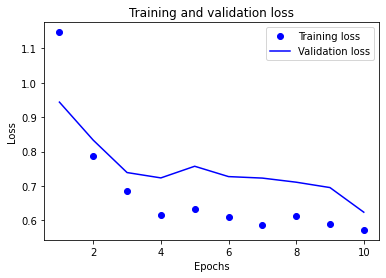

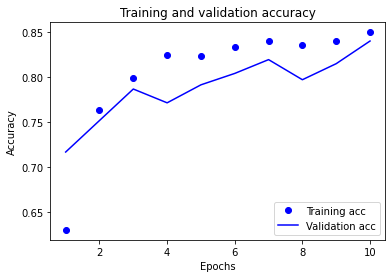

Model 2



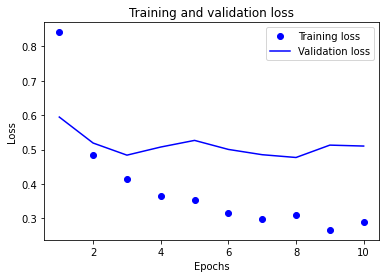

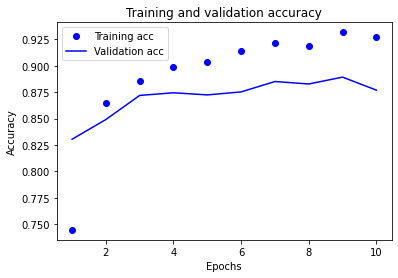

Model 3



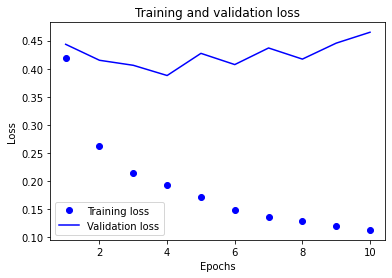

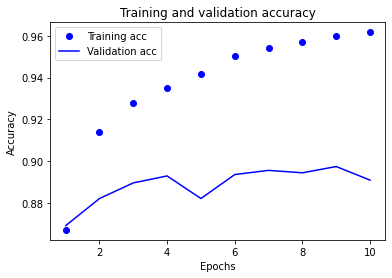

Model 4



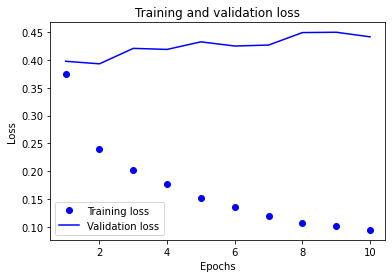

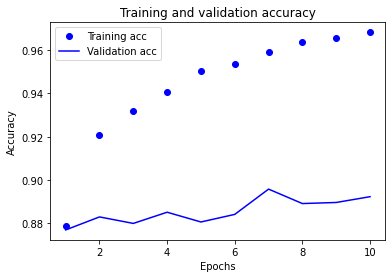

Model 5



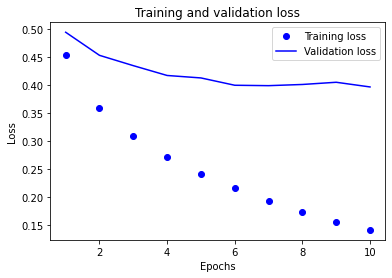

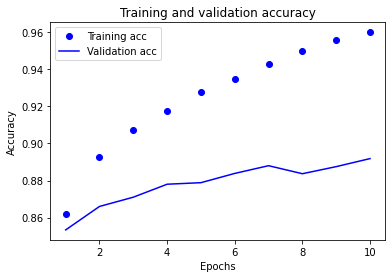

In [7]:
# init the ensemble model
ensemble_model = EnsembleModel(model_list)

# train the base models
ensemble_model.train_base_models(X_train, y_train, X_val, y_val, epochs=10)


In [8]:
# evaluate the ensemble on the validation set
y_val = np.argmax(y_val, axis=1)
acc_score_val = ensemble_model.predict_and_score(X_val, y_val)
print(f"Ensemble Accuracy on the validation set: {acc_score_val:.2f}")

# evaluate the ensemble on the test set
y_test = np.argmax(y_test, axis=1)
acc_score_test = ensemble_model.predict_and_score(X_test, y_test)
print(f"Ensemble Accuracy on the test set: {acc_score_test:.2f}")


Ensemble Accuracy on the validation set: 0.93
Ensemble Accuracy on the test set: 0.80
